# The Trickling Up of Excess Savings
*Adrien Auclert, Matthew Rognlie, Ludwig Straub*

*AEA: Papers and Proceedings, May 2023*

This notebook can be used to run all versions of the model in our paper, and to replicate the model outputs in Table 1 and Figure 4. (See the final part of the notebook for an exact replication of the formatted table and figure.)

To run the notebook, make sure that you have `ct_re_solver.py` in the same directory.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

# Baseline model

Equation (1) in the paper states that our general equilibrium economy, in deviations from steady state, is given by:

$$
c_{it} = m_ia_{it};~~~~~ \dot{a}_{it}=\theta_i Y_t - c_{it};~~~~~ Y_t = \sum_{i=1}^N c_{it} \tag{1}
$$

Stacking $m_i$, $\theta_i$, $c_{it}$ and $a_{it}$ in length-$N$ vectors $\mathbf{m}$, $\boldsymbol{\theta}$, $\mathbf{c}_t$, and $\mathbf{a}_t$, and defining the matrix $M=\text{diag}(\mathbf{m})$, we can combine the equations in (1) to obtain

$$
\dot{\mathbf{a}}_t = -M\mathbf{a}_t + \boldsymbol{\theta}\mathbf{m}'\mathbf{a}_t
$$

which is a simple $N$-dimensional linear differential equation.

We implement this below in the function `simulate_baseline`, which takes in the initial distribution of transfers $\mathbf{a}_0$ at date 0, the parameters $\mathbf{m}$ and $\boldsymbol{\theta}$, and the vector of times $t$ for which we want the solution. 

`ge=False` sets $\boldsymbol{\theta}$ to 0, shutting off GE income feedbacks and solving for the partial equilibrium trajectory of assets.

In [2]:
def simulate_baseline(a0, m, theta, ts, ge=True):
    # define matrix B so that adot = Ba, use matrix exponential as solution for each t
    # not the most efficient approach, but fine for this purpose
    B = -np.diag(m) + np.outer(ge*theta, m)
    a = np.stack([linalg.expm(t*B) @ a0 for t in ts], axis=-1)
    
    # return N*T matrix giving asset ("excess savings") path, T vector giving agg C
    return a, m @ a

We'll generally obtain results for 300 quarters, by which point "trickling up" will be essentially complete for all our calibrations.

In [3]:
ts = np.linspace(0, 300, 500)

## Baseline calibration
Let's try this on the basic calibration in our paper. We have three types, with:
   - (Loose) interpretation of types: bottom 80%, next 19%, top 1% of wealth 
   - Excess savings shares: 60%, 30% and 10%
   - Income shares (from SCF): 47%, 38% and 15%

In [4]:
a0     =  np.array([0.6, 0.3, 0.1])     # Initial excess savings shares
theta  =  np.array([0.47, 0.38, 0.15])  # Income shares
mpcs   =  np.array([0.4, 0.2, 0])       # Quarterly MPCs 
m      =  -np.log(1-mpcs)               # Convert to continuous time
labels = ['Bottom 80%', 'Next 19%', 'Top 1%']

Simulating the model:

In [5]:
a, C = simulate_baseline(a0, m, theta, ts)

What does the resulting path of excess savings look like? Let's plot for the first 40 quarters.

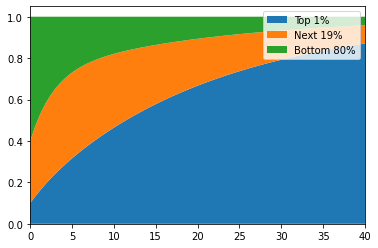

In [6]:
plt.stackplot(ts, a[2], a[1], a[0])
plt.xlim(0, 40)
plt.legend(labels[::-1]);

Here we see "trickling up" in action, with the bottom 80% starting with the largest share of excess savings when receiving the transfer, but then rapidly drawing it down. The next 19% has a nonmonotonic share, initially accumulating more from the boom, but eventually drawing it down. In the long run, all ends up with the top 1%.

In the "partial equilibrium" case where we disregard income feedbacks, we obtain rapid decumulation from everyone except the top 1%:

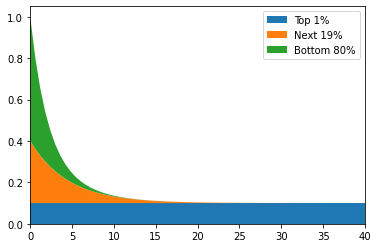

In [7]:
a_pe, C_pe = simulate_baseline(a0, m, theta, ts, ge=False)
plt.stackplot(ts, a_pe[2], a_pe[1], a_pe[0])
plt.xlim(0, 40)
plt.legend(labels[::-1]);

Let's see the contrasting effects on aggregate consumption in the two cases, where we see the far more persistent boom when accounting for income feedbacks in general equilibrium:

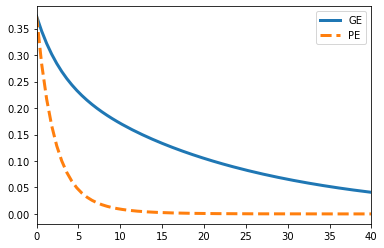

In [8]:
plt.plot(ts, C, linewidth=3, label='GE')
plt.plot(ts, C_pe, '--', linewidth=3, label='PE')
plt.xlim(0, 40)
plt.legend();

## Alternate calibrations of baseline model
We consider three alternate scenarios, for which we'll also plot the trajectory of excess savings. Feel free to play around with your own parameters!

*First*, a "lower MPC" scenario where we assume quarterly MPCs of 0.3 and 0.1 for the two lowest types, rather than 0.4 and 0.2. Here, as expected, as see slower trickling up:

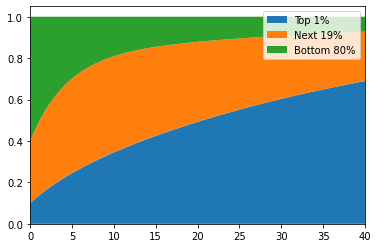

In [9]:
mpcs_1 = np.array([0.3, 0.1, 0])
m1 = -np.log(1-mpcs_1)   # convert to continuous time

a1, C1 = simulate_baseline(a0, m1, theta, ts)
plt.stackplot(ts, a1[2], a1[1], a1[0])
plt.xlim(0, 40)
plt.legend(labels[::-1]);

*Second*, a "more excess savings for rich" scenario, where a larger share of initial excess savings go to the "next 19%" group vs. the "bottom 80%". Here, less trickling up needs to take place:

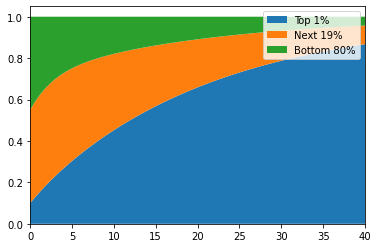

In [10]:
a02 = np.array([0.45, 0.45, 0.1])

a2, C2 = simulate_baseline(a02, m, theta, ts)
plt.stackplot(ts, a2[2], a2[1], a2[0])
plt.xlim(0, 40)
plt.legend(labels[::-1]);

*Third*, a "more earnings for rich" scenario, where a larger share of marginal earnings in the economy go to the "next 19%" group vs. the bottom 80%. Here, trickling up is a bit faster:

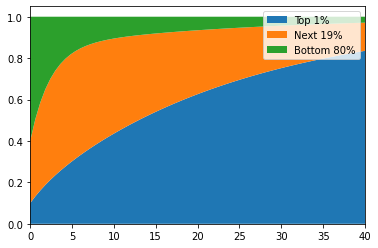

In [11]:
theta3 = np.array([0.3, 0.55, 0.15])

a3, C3 = simulate_baseline(a0, m, theta3, ts)
plt.stackplot(ts, a3[2], a3[1], a3[0])
plt.xlim(0, 40)
plt.legend(labels[::-1]);

# Extending the model: rational expectations
So far, we've assumed that there is no anticipatory spending by households out of future elevated income. This meant that the economy evolved mechanically according to an ordinary differential equation.

If we instead assume rational expectations, but maintain the assumption of $r=\rho=0$, the appendix to the paper shows that the system (assuming that households maximize subject to concave utility from assets) is now given by equation (17):

$$ \dot{c}_{it}=-m_{i}^{2}a_{it};\qquad\dot{a}_{it}=\theta_{i}Y_{t}-c_{it};\qquad Y_{t}=\sum_{i=1}^{N}c_{it} \tag{17} $$
This is a system
$$ \left(\begin{array}{c}
\dot{\mathbf{a}_{t}} \\ 
\dot{\mathbf{c}_{t}}
\end{array}\right)=\underbrace{\left(\begin{array}{cc}
0 & \boldsymbol{\theta}\mathbf{1}'-\mathbf{I}\\
-\Phi & 0
\end{array}\right)}_{\mathbf{A}}\left(\begin{array}{c}
\mathbf{a}_{t}\\
\mathbf{c}_{t}
\end{array}\right)
$$

where $\Phi$ is diagonal with $\Phi_{ii} = m_i^2$.

We'll build this matrix $\mathbf{A}$ and then call on a simple rational expectations solver from the `ct_re_solver.py` module.

*Important technical note: this function assumes that the final type is Ricardian, since to call the solver it needs to bypass this type to avoid its unit root.*

In [12]:
from ct_re_solver import solver

In [13]:
def simulate_re(a0, m, theta, ts):
    # drop last type (assume Ricardian), remember total assets
    atotal = a0.sum()
    a0, m, theta = a0[:-1], m[:-1], theta[:-1]
    
    # build A matrix
    N = len(m)
    A = np.block([[np.zeros((N,N)), -np.eye(N)+ np.outer(theta, np.ones(N))],
                  [np.diag(-m**2),  np.zeros((N,N))]])

    # obtain solution: adot = B*a, c = F*a
    B, F = solver(A, N)
    a = np.stack([linalg.expm(t*B) @ a0 for t in ts], axis=-1)
    C = F.sum(axis=0) @ a
    
    # add back final type's assets
    a = np.row_stack((a, atotal - a.sum(axis=0)))
    
    return a, C

In our baseline calibration, this leads to much faster trickling up, as households spend in anticipation of the boom:

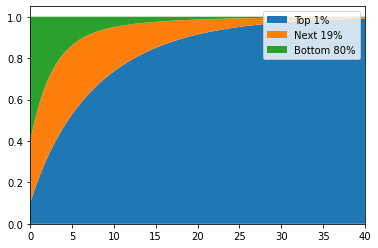

In [14]:
a_re, C_re = simulate_re(a0, m, theta, ts)

plt.stackplot(ts, a_re[2], a_re[1], a_re[0])
plt.xlim(0, 40)
plt.legend(labels[::-1]);

# Extending the model: monetary response
So far, we've also assumed that there is no response of real interest rates to the boom created by excess savings. One can imagine this being false in either direction: the monetary authority might aggressively push against the boom (in which case real rates would rise), or it might not raise nominal rates quickly enough to offset inflation (in which case they would fall).

Here, we suppose that real rates respond to demand in excess of steady state with a coefficient $\phi$: $r_t = \phi Y_t$. We return to assuming no anticipation of income changes, instead supposing that these households are "level 1" in the sense of Farhi and Werning, reacting to the anticipated path of real rates but not to anticipated general equilibrium deviations of income from steady state. To avoid needing to deal with income effects and specify a fiscal rule for the government, we also assume that steady-state assets are zero (which we interpret as a stand-in for most bonds having longer duration and being insulated from short-term rate changes).

The appendix shows that the economy is then characterized by equation (18):

$$
\dot{c}_{it}^P=m_{i}c_{it}^P+\sigma^{-1}\theta_i\phi Y_t;\qquad\dot{a}_{it}=\theta_{i}Y_{t}-m_i a_{it}-c_{it}^P;\qquad Y_{t}=\sum_{i=1}^{N}(m_ia_{it}+c_{it}^P) \tag{18} 
$$

where $c_{it}^P$ gives the effect on consumption for household $i$ that from anticipation of rates, which together with $m_ia_{it}$ gives its total deviation of consumption from steady state. $\sigma^{-1}$ is the elasticity of intertemporal substitution.

This can be stacked as a system

$$
\left(\begin{array}{c}
\dot{\mathbf{a}_{t}}\\
\dot{\mathbf{c}_{t}}^{P}
\end{array}\right)=\underbrace{\left(\begin{array}{cc}
\boldsymbol{\theta} m'-M & \boldsymbol{\theta}\mathbf{1}' - \mathbf{I}\\
\sigma^{-1}\phi\boldsymbol{\theta m'} & M+\sigma^{-1}\phi\boldsymbol{\theta1'}
\end{array}\right)}_{\mathbf{A}}\left(\begin{array}{c}
\mathbf{a}_{t}\\
\mathbf{c}_{t}^{P}
\end{array}\right)
$$

where $M\equiv \text{diag}(m)$. Again, we build `A` and call our solver routine.

In [15]:
def simulate_monetary(a0, sigma, m, theta, phi, ts):
    # build A matrix
    N = len(m)
    A = np.block([[np.outer(theta, m) - np.diag(m), np.outer(theta, np.ones(N)) - np.eye(N)],
                  [phi/sigma*np.outer(theta, m),    np.diag(m) + phi/sigma*np.outer(theta, np.ones(N))]])
    
    # delete row and column for Ricardian assets to avoid unit root (doesn't affect spending)
    A = np.delete(A, N-1, axis=0)
    A = np.delete(A, N-1, axis=1)
    
    # obtain solution: adot = B*a, cP = F*a, c = cP + m'a
    B, F = solver(A, N-1)
    a = np.stack([linalg.expm(t*B) @ a0[:-1] for t in ts], axis=-1)
    C = (F.sum(axis=0) + m[:-1]) @ a
    
    # add back final type's assets
    a = np.row_stack((a, a0.sum() - a.sum(axis=0)))
    
    return a, C

If we augment our baseline calibration with an active monetary policy response $\phi=1.5$,  and an EIS of 0.5, this also leads to faster trickling up, as richer households (especially the Ricardian ones) cut spending more than poor ones in response to higher rates.

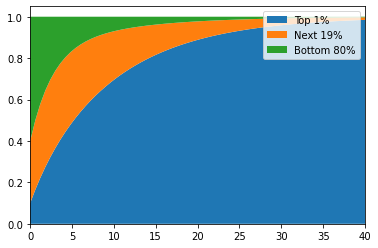

In [16]:
a_mp, C_mp = simulate_monetary(a0, 1/0.5, m, theta, 1.5, ts)

plt.stackplot(ts, a_mp[2], a_mp[1], a_mp[0])
plt.xlim(0, 40)
plt.legend(labels[::-1]);

# Table 1
We integrate our paths using Simpson's rule to obtain the duration of total consumption $\int tC_t \left/ \int C_t\right.$, etc. (We could calculate this more directly from the ODE, but the paths are smooth enough that this gives us a very accurate answer.)

First we will hardcode Simpson's rule, since `scipy.integrate.simpson` has only been recently added and is not in every SciPy distribution.

In [17]:
def simpson_weights(T):
    # get equispaced Simpson weights of 1, 4, 2, 4, 2, ..., 4, 1 all divided by 3
    assert T % 2 == 1, 'must have odd # of points, even # of intervals for standard Simpson rule'
    weights = 2 + 2*(np.arange(T) % 2 == 1)
    weights[0] -= 1
    weights[-1] -= 1
    return weights / 3

def simpson(y, x):
    # Integrate y(x) using Simpson's rule, assuming x is equispaced
    # could use scipy.integrate.simpson, but that was added recently
    T = len(x)
    if T % 2 == 1:
        # standard case with odd # of points, even # of intervals
        return (x[1] - x[0])*np.dot(simpson_weights(T), y)
    else:
        # even # of points, odd # of intervals, use Simpson's 3/8 rule on final 3 intervals as fix
        final_weights = (3/8)*np.array([1, 3, 3, 1])
        return (x[1] - x[0])*(np.dot(simpson_weights(T-3), y[:-3]) + np.dot(final_weights, y[-4:]))

Now we'll implement the duration formula:

In [18]:
def duration(X):
    return simpson(X*ts, ts) / simpson(X, ts)

The row-by-row output of Table 1 from the paper is displayed below:

In [19]:
print(f' PE C           = {duration(C_pe):.0f} Q  | a0 = {duration(a_pe[0]):.0f} Q  | a1 = {duration(a_pe[1]):.0f} Q') 
print(f' Benchmark C    = {duration(C):.0f} Q | a0 = {duration(a[0]):.0f} Q | a1 = {duration(a[1]):.0f} Q ') 
print(f' Scenario #1 C  = {duration(C1):.0f} Q | a0 = {duration(a1[0]):.0f} Q | a1 = {duration(a1[1]):.0f} Q  ') 
print(f' Scenario #2 C  = {duration(C2):.0f} Q | a0 = {duration(a2[0]):.0f} Q | a1 = {duration(a2[1]):.0f} Q  ') 
print(f' Scenario #3 C  = {duration(C3):.0f} Q | a0 = {duration(a3[0]):.0f} Q | a1 = {duration(a3[1]):.0f} Q ') 
print(f' Rational E C   = {duration(C_re):.0f} Q  | a0 = {duration(a_re[0]):.0f} Q  | a1 = {duration(a_re[1]):.0f} Q ') 
print(f' Tight mp C     = {duration(C_mp):.0f} Q  | a0 = {duration(a_mp[0]):.0f} Q  | a1 = {duration(a_mp[1]):.0f} Q') 

 PE C           = 3 Q  | a0 = 2 Q  | a1 = 4 Q
 Benchmark C    = 20 Q | a0 = 19 Q | a1 = 22 Q 
 Scenario #1 C  = 38 Q | a0 = 34 Q | a1 = 43 Q  
 Scenario #2 C  = 21 Q | a0 = 20 Q | a1 = 22 Q  
 Scenario #3 C  = 23 Q | a0 = 19 Q | a1 = 26 Q 
 Rational E C   = 8 Q  | a0 = 6 Q  | a1 = 10 Q 
 Tight mp C     = 8 Q  | a0 = 7 Q  | a1 = 11 Q


As a side note, we can also calculate the cumulative consumption response $\int C_t$ itself in each scenario, which is *equal* to exactly 6 across all scenarios except the first scenario (partial equilibrium) and final scenario (tight monetary policy) in our list:

In [20]:
np.array([simpson(Cx, ts) for Cx in (C_pe, C, C1, C2, C3, C_re, C_mp)]).round(2)

array([0.9 , 6.  , 6.  , 6.  , 6.  , 6.  , 0.82])

This reflects a general result for the general equilibrium case without a monetary policy response: the cumulative consumption (or equivalently output) response equals the initial excess savings of non-Ricardian households divided by the income share of the Ricardian one:

$$\frac{\sum_{i=1}^{N-1} a_{i0}}{\theta_N}$$

The reason for this result is that every dollar held by non-Ricardian households must eventually end up in the hands of the Ricardian household—but this only happens through increases in income, only $\theta_N$ of which are earned by the Ricardian household. The cumulative increase in income must therefore be $\theta_N^{-1}$ for all excess savings to eventually end up with the Ricardian household.

Since our basic general equilibrium scenarios do not change $\sum_{i=1}^{N-1} a_{i0}$ or $\theta_N$, we get the same cumulative response of 6 in all of them.

The partial equilibrium case is naturally an exception: there, all assets from non-Ricardian households are simply spent down, and cumulative consumption equals their initial share of excess savings.

The case with active monetary response is another exception: here, there is another way that excess savings end up with the Ricardian household, which is that it cuts its spending in response to higher real interest rates. This implies that much less of a cumulative output response is needed.

# Figure 4
The formatted Figure 4 from the paper is generated below, using the results we have already calculated, but scaling them by 6.7 to reflect estimated excess savings in 2022Q1 of 6.7% of GDP.

In [21]:
level = 6.7 # Excess savings in 2022Q1 = 6.7% of GDP

In [22]:
# uncomment this to get exact font and style in paper
# plt.rc('text', usetex=True)
# plt.rc('font', family = 'serif')
# plt.rc('text.latex', preamble=r'\usepackage{mathpazo}')
# plt.rc('font', size=12)
# labels = ['Bottom 80\%', 'Next 19\%', 'Top 1\%']

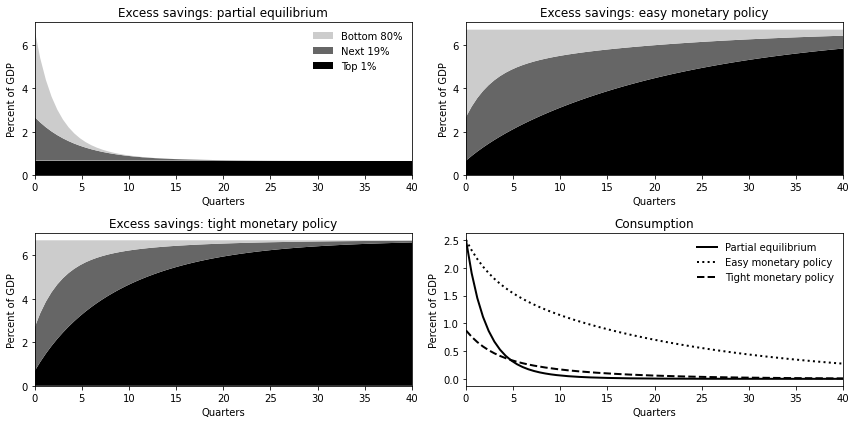

In [23]:
fig, ax1 = plt.subplots(2,2,figsize=(12,6))

ax1[0,0].stackplot(ts, level*a_pe[2], level*a_pe[1], level*a_pe[0],  labels = labels[::-1], colors=['k', '#666666', '#CCCCCC']) 
ax1[0,0].set_ylabel('Percent of GDP')
ax1[0,0].set_title('Excess savings: partial equilibrium')
ax1[0,0].set_xlim(0,40)
ax1[0,0].set_xlabel('Quarters')
# Reverse legend order for readability
handles, labels = ax1[0,0].get_legend_handles_labels()
ax1[0,0].legend(handles[::-1], labels[::-1], loc='upper right', framealpha=0)

ax1[0,1].stackplot(ts, level*a[2], level*a[1],level*a[0], colors=['k', '#666666', '#CCCCCC']) 
ax1[0,1].set_ylabel('Percent of GDP')
ax1[0,1].set_title('Excess savings: easy monetary policy')
ax1[0,1].set_xlabel('Quarters')
ax1[0,1].set_xlim(0,40)

ax1[1,0].stackplot(ts, level*a_mp[2], level*a_mp[1],level*a_mp[0], colors=['k', '#666666', '#CCCCCC']) 
ax1[1,0].set_ylabel('Percent of GDP')
ax1[1,0].set_title('Excess savings: tight monetary policy')
ax1[1,0].set_xlabel('Quarters')
ax1[1,0].set_xlim(0,40)

ax1[1,1].plot(ts, level*C_pe, linewidth = 2, label='Partial equilibrium', color='k')
ax1[1,1].plot(ts, level*C, linewidth = 2, label='Easy monetary policy', color='k', linestyle=':')
ax1[1,1].plot(ts, level*C_mp, linewidth = 2, label='Tight monetary policy', color='k', linestyle='--')
ax1[1,1].tick_params(axis='both', which='major') 
ax1[1,1].legend(framealpha=0)
ax1[1,1].set_title('Consumption')
ax1[1,1].set_ylabel('Percent of GDP')
ax1[1,1].set_xlabel('Quarters')
ax1[1,1].set_xlim(0,40)

plt.tight_layout();
plt.savefig(f'Figure4.pdf', transparent=True);